In [1]:
using DifferentialEquations
using Plots

In [81]:
function DDOL_2modules(du,u,p,t)

    v00,v10,v01,v11 = u
    bA,bB,n,umax,G,r,D,cA,cB,dA,dB = p
    v_populations = [ v00 , v10 , v01 , v11 ]
    total_pop = sum( v_populations )
    
    u_00 = ( umax * G ) / ( 1.0 + ( 0 * bA + 0 * bB ) ^ n )
    u_10 = ( umax * G ) / ( 1.0 + ( 1 * bA + 0 * bB ) ^ n )
    u_01 = ( umax * G ) / ( 1.0 + ( 0 * bA + 1 * bB ) ^ n )
    u_11 = ( umax * G ) / ( 1.0 + ( 1 * bA + 1 * bB ) ^ n )
    
    v00_growth = u_00 * v00 * ( 1.0 - ( total_pop / r ) ) - D * v00
    v10_growth = u_10 * v10 * ( 1.0 - ( total_pop / r ) ) - D * v10
    v01_growth = u_01 * v01 * ( 1.0 - ( total_pop / r ) ) - D * v01
    v11_growth = u_11 * v11 * ( 1.0 - ( total_pop / r ) ) - D * v11
    
    modA = cA * ( v10 + v11 )
    modB = cB * ( v01 + v11 )
    
    v00_conjugation = ( - ( modA * v00 ) + ( dA * v10 ) 
                        - ( modB * v00 ) + ( dB * v01 ) )
    v10_conjugation = ( + ( modA * v00 ) - ( dA * v10 )
                        - ( modB * v10 ) + ( dB * v11 ) )
    v01_conjugation = ( - ( modA * v01 ) + ( dA * v11 ) 
                        + ( modB * v00 ) - ( dB * v01 ) )  
    v11_conjugation = ( + ( modA * v01 ) - ( dA * v11 ) 
                        + ( modB * v10 ) - ( dB * v11 ) )

    du[1] = dv00 = v00_conjugation + v00_growth
    du[2] = dv10 = v10_conjugation + v10_growth
    du[3] = dv01 = v01_conjugation + v01_growth
    du[4] = dv11 = v11_conjugation + v11_growth
    
end

function monoculture_with_dual_selection(du,u,p,t)
    vM = u[1]
    burden,n,umax,G,r,D = p
    
    u_M = ( umax * G ) / ( 1.0 + ( burden ) ^ n )
    
    vM_growth = u_M * vM * ( 1.0 - ( vM / r ) ) - D * vM

    du[1] = dvM = vM_growth
end

function SDOL_2modules(du,u,p,t)
    vA,vB = u
    bA,bB,n,umax,G,r,D,dA,dB = p
    v_populations = [ vA , vB ]
    total_pop = sum( v_populations )
    
    u_A = ( umax * G ) / ( 1.0 + ( 1 * bA + 0 * bB ) ^ n )
    u_B = ( umax * G ) / ( 1.0 + ( 0 * bA + 1 * bB ) ^ n )
    
    vA_growth = u_A * vA * ( 1.0 - ( total_pop / r ) ) - D * vA
    vB_growth = u_B * vB * ( 1.0 - ( total_pop / r ) ) - D * vB
    
    
    du[1] = dv10 = vA_growth
    du[2] = dv01 = vB_growth
end

persistence_potential(c,umax,D,d,b) = c / ( ( umax / (umax - D) ) * ( D + d - D / (1 + b) ) )

persistence_potential (generic function with 1 method)

In [150]:
c_range = 0:0.002:0.1
avg_c = 0.1

transfer_rates = [0,0.01,0.02,0.05,0.1]

avg_umax = 1

D_range = 0:0.001:0.1
avg_D = 0.05

dilution_rates = [0,0.001,0.005,0.01,0.05]

d_range = 0:0.001:1
avg_d = 1e-3

b_range = 0:0.1:15
avg_b = 1

n_range = 1:0.01:10
avg_n = 3

G_range = 0:0.01:1
avg_G = 1

avg_r = 1

simulation_time = 300

300

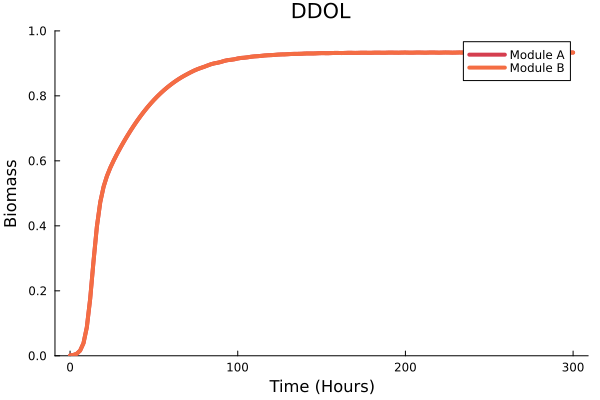

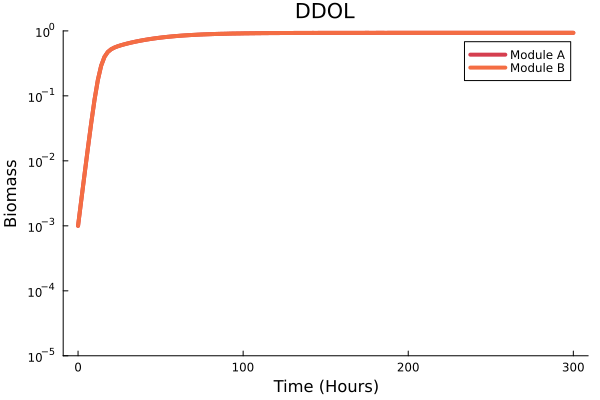

Estimated Persistance Potential of Plasmid A: 8.636363636363635
Estimated Persistance Potential of Plasmid B: 8.636363636363635

In [126]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 0.5
symmetrical_burden = total_burden/2

bA = symmetrical_burden
bB = symmetrical_burden

n = avg_n
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d
cA = avg_c
cB = avg_c
simulation_time = 300

# u = [v00,v10, v01, v11]
u0 = [0,1e-3,1e-3,0] # Initial values for S0, S1, S2, S3

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  bA, bB, n, umax, G, r, D, cA, cB, dA, dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
 
bA,bB,n,umax,G,r,D,cA,cB,dA,dB = p

persistence_potential_A = persistence_potential(cA,umax,D,dA,bA)
println("Estimated Persistance Potential of Plasmid A: $persistence_potential_A" )

persistence_potential_B = persistence_potential(cB,umax,D,dB,bB)
print("Estimated Persistance Potential of Plasmid B: $persistence_potential_B" )


time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

# Time span for integration
tspan = (0.0, tspan_end)  # Start and end times for integration

# Define the ODE problem
prob = ODEProblem(DDOL_2modules, u0, tspan, p)

# Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
solver = Tsit5()

# Solve the ODE problem
sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

population_volumes = (sol[1, :]/r,sol[2, :]/r,sol[3, :]/r,sol[4, :]/r)
total_biomass = sum(population_volumes)
productive_biomass = total_biomass - sol[1, :]/r
module_A = sol[2, :]/r + sol[4, :]/r
module_B = sol[3, :]/r + sol[4, :]/r

# Create the publication-quality plot using native Julia plotting
gr(color_palette=:Spectral_8, linewidth=4)

dynamics_plot = plot()

#=
plot!(sol.t/dP, sol[1, :]/r, label="v00")
plot!(sol.t/dP, sol[2, :]/r, label="v10")
plot!(sol.t/dP, sol[3, :]/r, label="v01")
plot!(sol.t/dP, sol[4, :]/r, label="v11")


plot!(sol.t/dP, total_biomass, label="Total")
plot!(sol.t/dP, productive_biomass, label="Productive")
=#

plot!(sol.t/dP, module_A, label="Module A")
plot!(sol.t/dP, module_B, label="Module B")


xlabel!("Time (Hours)")
ylabel!("Biomass")
title!("DDOL")
plot!(legend=:topright)
plot!(grid=:false)
plot!(ylim=(0,1))
display(dynamics_plot)

#savefig(dynamics_plot,"DDOL.svg")

plot!(yaxis=:log)
plot!(ylim=(1e-5,1))
display(dynamics_plot)


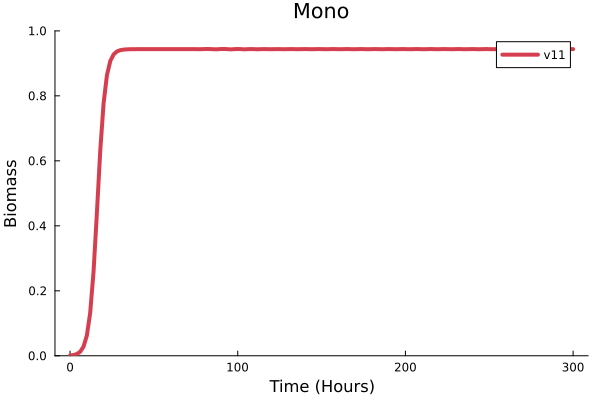

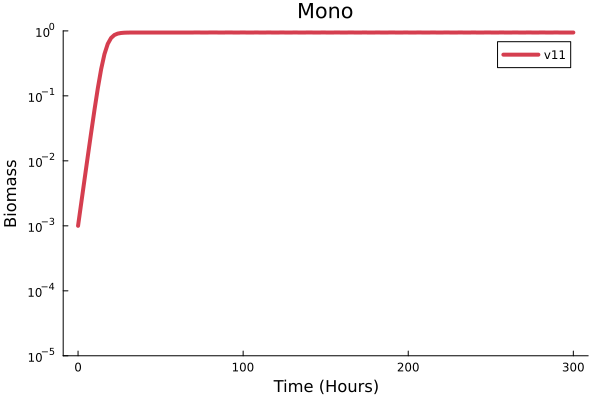

In [127]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 0.5

simulation_time = 300

# u = [v11]
u0 = [1e-3] # Initial values for v11

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  total_burden, n, umax, G, r, D] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
 

time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

# Time span for integration
tspan = (0.0, tspan_end)  # Start and end times for integration

# Define the ODE problem
prob = ODEProblem(monoculture_with_dual_selection, u0, tspan, p)

# Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
solver = Tsit5()

# Solve the ODE problem
sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

# Create the publication-quality plot using native Julia plotting
gr(color_palette=:Spectral_8, linewidth=4)

dynamics_plot = plot()

plot!(sol.t/dP, sol[1, :]/r, label="v11")

xlabel!("Time (Hours)")
ylabel!("Biomass")
title!("Mono")
plot!(legend=:topright)
plot!(grid=:false)
plot!(ylim=(0,1))
display(dynamics_plot)

#savefig(dynamics_plot,"Mono.svg")

plot!(yaxis=:log)
plot!(ylim=(1e-5,1))
display(dynamics_plot)

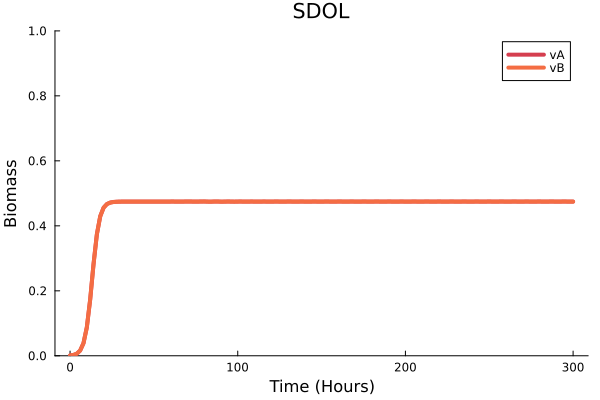

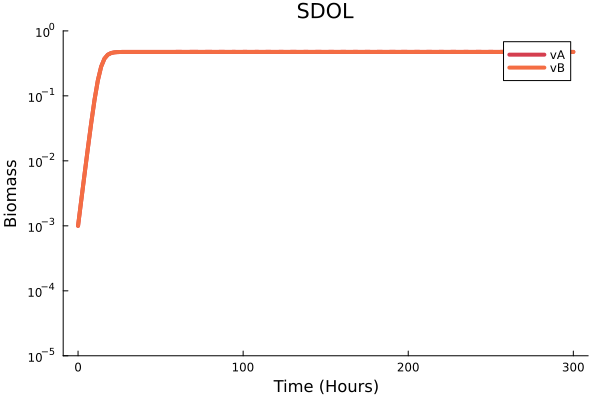

In [128]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 0.5
symmetrical_burden = total_burden/2

bA = symmetrical_burden
bB = symmetrical_burden

# u = [v10, v01]
u0 = [1e-3,1e-3] # Initial values for SA, SB

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  bA, bB, n, umax, G, r, D, cA, cB, dA, dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

# Time span for integration
tspan = (0.0, tspan_end)  # Start and end times for integration

# Define the ODE problem
prob = ODEProblem(SDOL_2modules, u0, tspan, p)

# Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
solver = Tsit5()

# Solve the ODE problem
sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

#=
population_volumes = (sol[1, :]/r,sol[2, :]/r)
total_biomass = sum(population_volumes)
module_A = sol[2, :]/r
module_B = sol[3, :]/r
=#

# Create the publication-quality plot using native Julia plotting
gr(color_palette=:Spectral_8, linewidth=4)

dynamics_plot = plot()

plot!(sol.t/dP, sol[1, :]/r, label="vA")
plot!(sol.t/dP, sol[2, :]/r, label="vB")

xlabel!("Time (Hours)")
ylabel!("Biomass")
title!("SDOL")
plot!(legend=:topright)
plot!(grid=:false)
plot!(ylim=(0,1))
display(dynamics_plot)

#savefig(dynamics_plot,"SDOL.svg")

plot!(yaxis=:log)
plot!(ylim=(1e-5,1))
display(dynamics_plot)

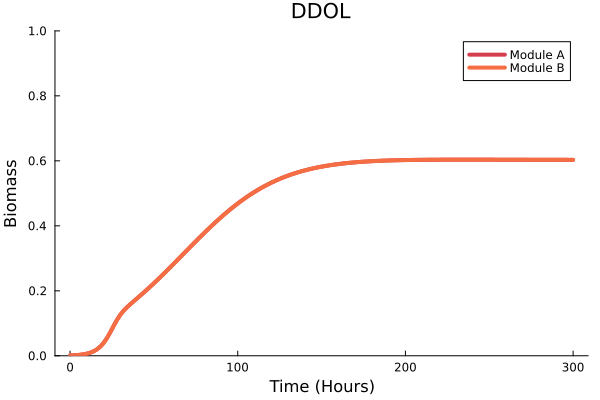

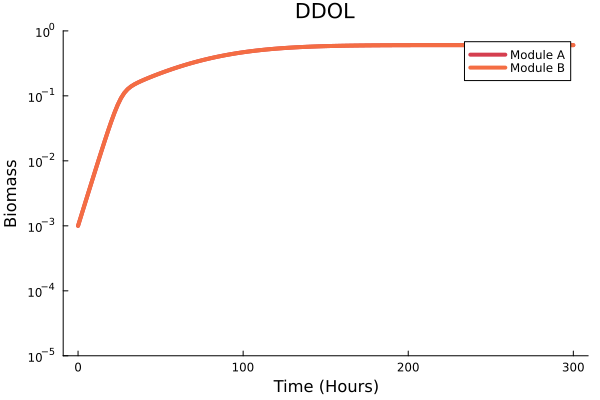

Estimated Persistance Potential of Plasmid A: 3.4938704028021013
Estimated Persistance Potential of Plasmid B: 3.4938704028021013

In [123]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 2.2
symmetrical_burden = total_burden/2

bA = symmetrical_burden
bB = symmetrical_burden

n = avg_n
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d
cA = avg_c
cB = avg_c
simulation_time = 300

# u = [v00,v10, v01, v11]
u0 = [0,1e-3,1e-3,0] # Initial values for S0, S1, S2, S3

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  bA, bB, n, umax, G, r, D, cA, cB, dA, dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
 
bA,bB,n,umax,G,r,D,cA,cB,dA,dB = p

persistence_potential_A = persistence_potential(cA,umax,D,dA,bA)
println("Estimated Persistance Potential of Plasmid A: $persistence_potential_A" )

persistence_potential_B = persistence_potential(cB,umax,D,dB,bB)
print("Estimated Persistance Potential of Plasmid B: $persistence_potential_B" )


time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

# Time span for integration
tspan = (0.0, tspan_end)  # Start and end times for integration

# Define the ODE problem
prob = ODEProblem(DDOL_2modules, u0, tspan, p)

# Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
solver = Tsit5()

# Solve the ODE problem
sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

population_volumes = (sol[1, :]/r,sol[2, :]/r,sol[3, :]/r,sol[4, :]/r)
total_biomass = sum(population_volumes)
productive_biomass = total_biomass - sol[1, :]/r
module_A = sol[2, :]/r + sol[4, :]/r
module_B = sol[3, :]/r + sol[4, :]/r

# Create the publication-quality plot using native Julia plotting
gr(color_palette=:Spectral_8, linewidth=4)

dynamics_plot = plot()

#=
plot!(sol.t/dP, sol[1, :]/r, label="v00")
plot!(sol.t/dP, sol[2, :]/r, label="v10")
plot!(sol.t/dP, sol[3, :]/r, label="v01")
plot!(sol.t/dP, sol[4, :]/r, label="v11")


plot!(sol.t/dP, total_biomass, label="Total")
plot!(sol.t/dP, productive_biomass, label="Productive")
=#

plot!(sol.t/dP, module_A, label="Module A")
plot!(sol.t/dP, module_B, label="Module B")


xlabel!("Time (Hours)")
ylabel!("Biomass")
title!("DDOL")
plot!(legend=:topright)
plot!(grid=:false)
plot!(ylim=(0,1))
display(dynamics_plot)

#savefig(dynamics_plot,"DDOL.svg")

plot!(yaxis=:log)
plot!(ylim=(1e-5,1))
display(dynamics_plot)


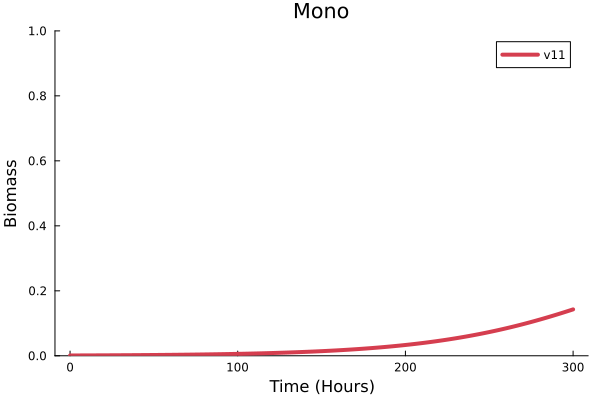

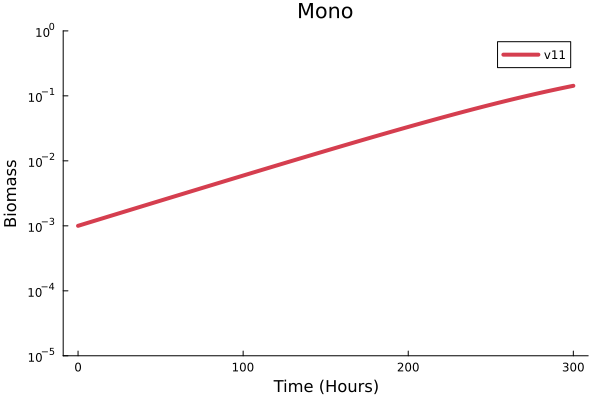

In [124]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 2.2

simulation_time = 300

# u = [v11]
u0 = [1e-3] # Initial values for v11

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  total_burden, n, umax, G, r, D] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
 

time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

# Time span for integration
tspan = (0.0, tspan_end)  # Start and end times for integration

# Define the ODE problem
prob = ODEProblem(monoculture_with_dual_selection, u0, tspan, p)

# Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
solver = Tsit5()

# Solve the ODE problem
sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

# Create the publication-quality plot using native Julia plotting
gr(color_palette=:Spectral_8, linewidth=4)

dynamics_plot = plot()

plot!(sol.t/dP, sol[1, :]/r, label="v11")

xlabel!("Time (Hours)")
ylabel!("Biomass")
title!("Mono")
plot!(legend=:topright)
plot!(grid=:false)
plot!(ylim=(0,1))
display(dynamics_plot)

#savefig(dynamics_plot,"Mono.svg")

plot!(yaxis=:log)
plot!(ylim=(1e-5,1))
display(dynamics_plot)

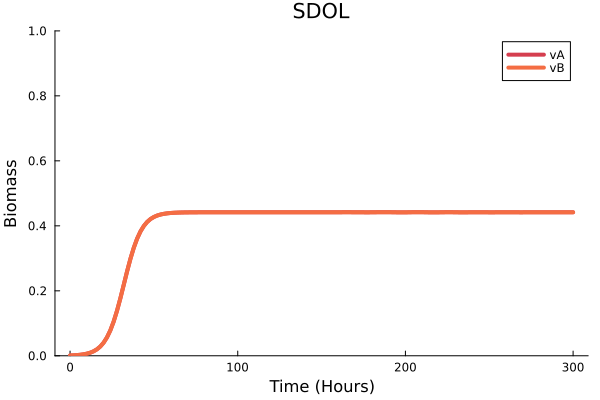

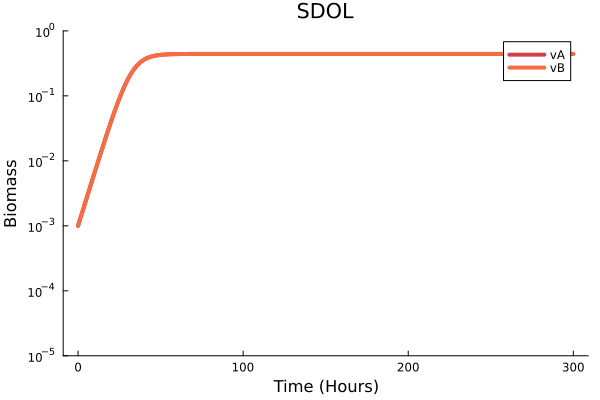

In [125]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 2.2
symmetrical_burden = total_burden/2

bA = symmetrical_burden
bB = symmetrical_burden


# u = [v10, v01]
u0 = [1e-3,1e-3] # Initial values for SA, SB

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  bA, bB, n, umax, G, r, D, cA, cB, dA, dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

# Time span for integration
tspan = (0.0, tspan_end)  # Start and end times for integration

# Define the ODE problem
prob = ODEProblem(SDOL_2modules, u0, tspan, p)

# Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
solver = Tsit5()

# Solve the ODE problem
sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

#=
population_volumes = (sol[1, :]/r,sol[2, :]/r)
total_biomass = sum(population_volumes)
module_A = sol[2, :]/r
module_B = sol[3, :]/r
=#

# Create the publication-quality plot using native Julia plotting
gr(color_palette=:Spectral_8, linewidth=4)

dynamics_plot = plot()

plot!(sol.t/dP, sol[1, :]/r, label="vA")
plot!(sol.t/dP, sol[2, :]/r, label="vB")

xlabel!("Time (Hours)")
ylabel!("Biomass")
title!("SDOL")
plot!(legend=:topright)
plot!(grid=:false)
plot!(ylim=(0,1))
display(dynamics_plot)

#savefig(dynamics_plot,"SDOL.svg")

plot!(yaxis=:log)
plot!(ylim=(1e-5,1))
display(dynamics_plot)

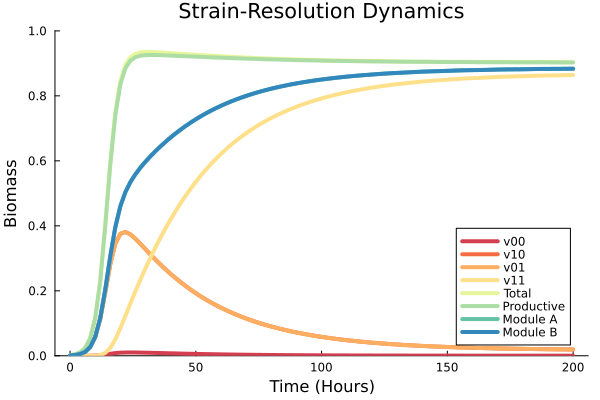

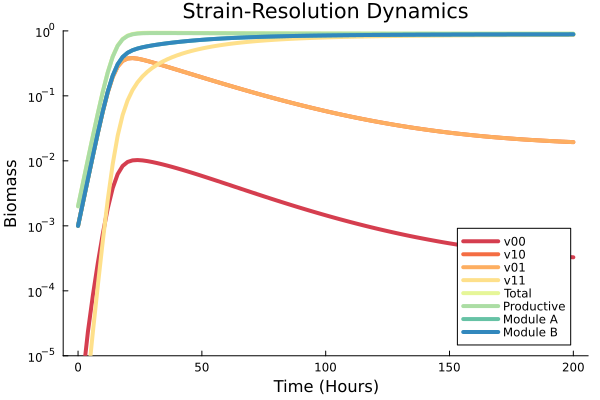

Estimated Persistance Potential of Plasmid A: 5.377358490566038
Estimated Persistance Potential of Plasmid B: 5.377358490566038

In [131]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 1
symmetrical_burden = total_burden/2

bA = symmetrical_burden
bB = symmetrical_burden

n = 3
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d
cA = avg_c
cB = avg_c
simulation_time = 200

# u = [v00,v10, v01, v11]
u0 = [0,1e-3,1e-3,0] # Initial values for S0, S1, S2, S3

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  bA, bB, n, umax, G, r, D, cA, cB, dA, dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
 
bA,bB,n,umax,G,r,D,cA,cB,dA,dB = p

persistence_potential_A = persistence_potential(cA,umax,D,dA,bA)
println("Estimated Persistance Potential of Plasmid A: $persistence_potential_A" )

persistence_potential_B = persistence_potential(cB,umax,D,dB,bB)
print("Estimated Persistance Potential of Plasmid B: $persistence_potential_B" )


time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

# Time span for integration
tspan = (0.0, tspan_end)  # Start and end times for integration

# Define the ODE problem
prob = ODEProblem(DDOL_2modules, u0, tspan, p)

# Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
solver = Tsit5()

# Solve the ODE problem
sol = solve(prob, solver, saveat=1);  # Here, we specify `saveat` for regular time intervals.

population_volumes = (sol[1, :]/r,sol[2, :]/r,sol[3, :]/r,sol[4, :]/r)
total_biomass = sum(population_volumes)
productive_biomass = total_biomass - sol[1, :]/r
module_A = sol[2, :]/r + sol[4, :]/r
module_B = sol[3, :]/r + sol[4, :]/r

# Create the publication-quality plot using native Julia plotting
gr(color_palette=:Spectral_8, linewidth=4)

dynamics_plot = plot()

plot!(sol.t/dP, sol[1, :]/r, label="v00")
plot!(sol.t/dP, sol[2, :]/r, label="v10")
plot!(sol.t/dP, sol[3, :]/r, label="v01")
plot!(sol.t/dP, sol[4, :]/r, label="v11")
plot!(sol.t/dP, total_biomass, label="Total")
plot!(sol.t/dP, productive_biomass, label="Productive")
plot!(sol.t/dP, module_A, label="Module A")
plot!(sol.t/dP, module_B, label="Module B")

xlabel!("Time (Hours)")
ylabel!("Biomass")
title!("Strain-Resolution Dynamics")
plot!(legend=:bottomright)
plot!(grid=:false)
plot!(ylim=(0,1))
display(dynamics_plot)

#savefig(dynamics_plot,"strain_resolution_dynamics.svg")

plot!(yaxis=:log)
plot!(ylim=(1e-5,1))
display(dynamics_plot)

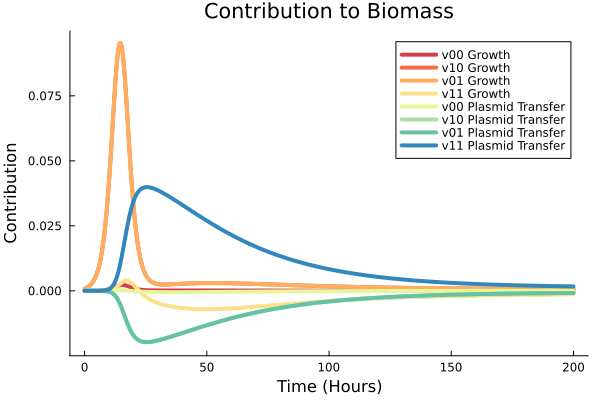

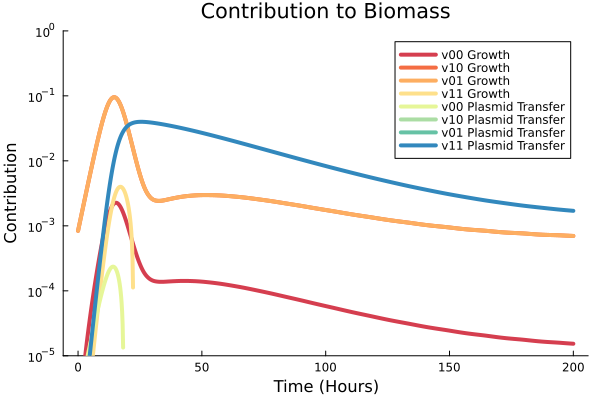

Estimated Persistance Potential of Plasmid A: 5.377358490566038
Estimated Persistance Potential of Plasmid B: 5.377358490566038

In [141]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 1
symmetrical_burden = total_burden/2

bA = symmetrical_burden
bB = symmetrical_burden

n = 3
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d
cA = avg_c
cB = avg_c
simulation_time = 200

# u = [v00,v10, v01, v11]
u0 = [0,1e-3,1e-3,0] # Initial values for S0, S1, S2, S3

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  bA, bB, n, umax, G, r, D, cA, cB, dA, dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
 
bA,bB,n,umax,G,r,D,cA,cB,dA,dB = p

persistence_potential_A = persistence_potential(cA,umax,D,dA,bA)
println("Estimated Persistance Potential of Plasmid A: $persistence_potential_A" )

persistence_potential_B = persistence_potential(cB,umax,D,dB,bB)
print("Estimated Persistance Potential of Plasmid B: $persistence_potential_B" )


time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

# Time span for integration
tspan = (0.0, tspan_end)  # Start and end times for integration

# Define the ODE problem
prob = ODEProblem(DDOL_2modules, u0, tspan, p)

# Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
solver = Tsit5()

# Solve the ODE problem
sol = solve(prob, solver, saveat=0.1);  # Here, we specify `saveat` for regular time intervals.

v00 = sol[1, :]/r
v10 = sol[2, :]/r
v01 = sol[3, :]/r
v11 = sol[4, :]/r

v_populations = [ v00 , v10 , v01 , v11 ]
total_pop = sum( v_populations )

u_00 = ( umax * G ) / ( 1.0 + ( 0 * bA + 0 * bB ) ^ n )
u_10 = ( umax * G ) / ( 1.0 + ( 1 * bA + 0 * bB ) ^ n )
u_01 = ( umax * G ) / ( 1.0 + ( 0 * bA + 1 * bB ) ^ n )
u_11 = ( umax * G ) / ( 1.0 + ( 1 * bA + 1 * bB ) ^ n )

v00_growth = u_00 .* v00 .* ( 1.0 .- ( total_pop ./ r ) ) - D .* v00
v10_growth = u_10 .* v10 .* ( 1.0 .- ( total_pop ./ r ) ) - D .* v10
v01_growth = u_01 .* v01 .* ( 1.0 .- ( total_pop ./ r ) ) - D .* v01
v11_growth = u_11 .* v11 .* ( 1.0 .- ( total_pop ./ r ) ) - D .* v11
    
modA = cA .* ( v10 + v11 )
modB = cB .* ( v01 + v11 )
    
v00_conjugation = ( - ( modA .* v00 ) + ( dA .* v10 ) 
                    - ( modB .* v00 ) + ( dB .* v01 ) )
v10_conjugation = ( + ( modA .* v00 ) - ( dA .* v10 )
                    - ( modB .* v10 ) + ( dB .* v11 ) )
v01_conjugation = ( - ( modA .* v01 ) + ( dA .* v11 ) 
                    + ( modB .* v00 ) - ( dB .* v01 ) )  
v11_conjugation = ( + ( modA .* v01 ) - ( dA .* v11 ) 
                    + ( modB .* v10 ) - ( dB .* v11 ) )


# Create the publication-quality plot using native Julia plotting
gr(linecolor=:auto,color_palette=:Spectral_8, linewidth=4, linealpha=1)

dynamics_contributions_c = plot()

plot!(sol.t/dP, v00_growth, label="v00 Growth")
plot!(sol.t/dP, v10_growth, label="v10 Growth")
plot!(sol.t/dP, v01_growth, label="v01 Growth")
plot!(sol.t/dP, v11_growth, label="v11 Growth")
#plot!(sol.t/dP, total_growth, label="Total Growth")

plot!(sol.t/dP, v00_conjugation, label="v00 Plasmid Transfer")
plot!(sol.t/dP, v10_conjugation, label="v10 Plasmid Transfer")
plot!(sol.t/dP, v01_conjugation, label="v01 Plasmid Transfer")
plot!(sol.t/dP, v11_conjugation, label="v11 Plasmid Transfer")

xlabel!("Time (Hours)")
ylabel!("Contribution")
title!("Contribution to Biomass")
plot!(legend=:topright)
plot!(grid=:false)
plot!(ylim=(-0.025,0.1))
display(dynamics_contributions_c)

#savefig(dynamics_contributions_c,"dynamics_contributions.svg")

plot!(yaxis=:log)
plot!(ylim=(1e-5,1))
display(dynamics_contributions_c)

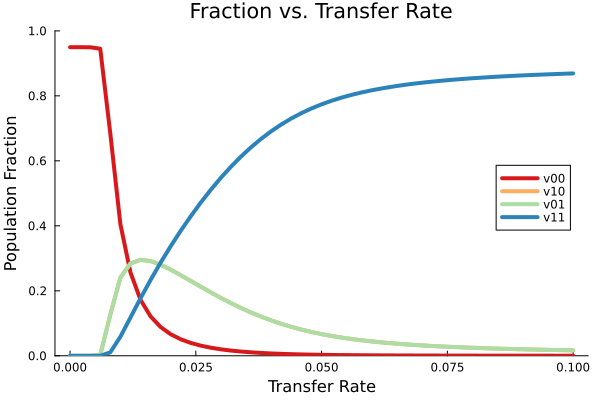

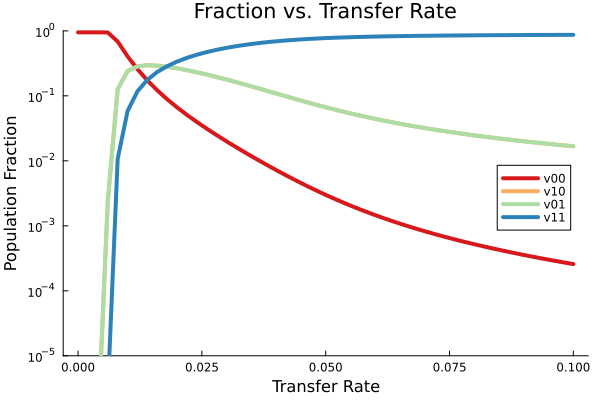

Estimated Persistance Potential of Plasmid A: 5.377358490566038
Estimated Persistance Potential of Plasmid B: 5.377358490566038

In [152]:
# Initial conditions and parameter values
# p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
total_burden = 1
symmetrical_burden = total_burden/2

bA = symmetrical_burden
bB = symmetrical_burden

n = 3
umax = avg_umax
G = avg_G
r = avg_r
D = avg_D
dA = avg_d
dB = avg_d
cA = avg_c
cB = avg_c
simulation_time = 10000

# u = [v00,v10, v01, v11]
u0 = [0,1e-3,1e-3,0] # Initial values for S0, S1, S2, S3

# p = (bA, bB, n, umax, G, r, D, cA, cB, dA, dB)
p = [  bA, bB, n, umax, G, r, D, cA, cB, dA, dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB
 
bA,bB,n,umax,G,r,D,cA,cB,dA,dB = p

persistence_potential_A = persistence_potential(cA,umax,D,dA,bA)
println("Estimated Persistance Potential of Plasmid A: $persistence_potential_A" )

persistence_potential_B = persistence_potential(cB,umax,D,dB,bB)
print("Estimated Persistance Potential of Plasmid B: $persistence_potential_B" )


time = simulation_time # simulated time IN HOURS
dP = 0.5 # Turnover rate of final product (non-dimensionalization term)
tspan_end = time * dP

transfer_range = c_range

strain_list = [ "v00", "v10", "v01", "v11" ]

steady_state_solutions = Array{Float64}(undef,4,length(transfer_range))


for transfer_index in range(1,length(transfer_range))
    
    transfer_rate = transfer_range[transfer_index]
    
    # Initial conditions and parameter values

    # u = [v00,v10, v01, v11]
    u0 = [0.0,1e-3,1e-3,0.0000] # Initial values for S0, S1, S2, S3

    # p = (bA, bB, n,  umax,G,  r,    D,   cA,  cB,  dA,   dB)
    p = [  symmetrical_burden,symmetrical_burden,n,umax,G,r,D,transfer_rate,transfer_rate,dA,dB] # Parameters: bA,bB,n,umax,G,r,D,cA,cB,dA,dB

    # Time span for integration
    tspan = (0.0, tspan_end)  # Start and end times for integration

    # Define the ODE problem
    prob = ODEProblem(DDOL_2modules, u0, tspan, p)

    # Choose a solver (e.g., `Tsit5()` - an efficient low-order adaptive Runge-Kutta method)
    solver = Tsit5()

    # Solve the ODE problem
    sol = solve(prob, solver, saveat=0.01);  # Here, we specify `saveat` for regular time intervals.

    v00 = sol[1, :]/r
    v10 = sol[2, :]/r
    v01 = sol[3, :]/r 
    v11 = sol[4, :]/r


    v00_SS = max(0,last(v00))
    v10_SS = max(0,last(v10))
    v01_SS = max(0,last(v01))
    v11_SS = max(0,last(v11))


    steady_state_solutions[1,transfer_index] = v00_SS
    steady_state_solutions[2,transfer_index] = v10_SS
    steady_state_solutions[3,transfer_index] = v01_SS
    steady_state_solutions[4,transfer_index] = v11_SS
end


# Create the publication-quality plot using native Julia plotting
gr(color_palette=:Spectral_4, linewidth=4)

comparison_plot = plot()
xlabel!("Transfer Rate")
ylabel!("Population Fraction")
title!("Fraction vs. Transfer Rate")
plot!(legend=:right)
plot!(grid=:false)
plot!(ylim=(0,1))


for index in range(1,4)
    
    strain = strain_list[index]
    
    plot!(c_range, steady_state_solutions[index,:],label="$strain")

end


display(comparison_plot)

savefig(comparison_plot,"population_fractions.svg")


plot!(yaxis=:log)
plot!(ylim=(1e-5,1))

display(comparison_plot)